##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow basics

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/guide/basics"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/basics.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/guide/basics.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/guide/basics.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This guide provides a quick overview of _TensorFlow basics_. Each section of this doc is an overview of a larger topic—you can find links to full guides at the end of each section.

TensorFlow is an end-to-end platform for machine learning. It supports the following:

* Multidimensional-array based numeric computation (similar to <a href="https://numpy.org/" class="external">NumPy</a>.)
* GPU and distributed processing
* Automatic differentiation
* Model construction, training, and export
* And more

## Tensors

TensorFlow operates on multidimensional arrays or _tensors_ represented as `tf.Tensor` objects. Here is a two-dimensional tensor:

In [ ]:
import tensorflow as tf

x = tf.constant([[1., 2., 3.],
                 [4., 5., 6.]])

print(x)
print(x.shape)
print(x.dtype)

The most important attributes of a `tf.Tensor` are its `shape` and `dtype`:

* `Tensor.shape`: tells you the size of the tensor along each of its axes.
* `Tensor.dtype`: tells you the type of all the elements in the tensor.

TensorFlow implements standard mathematical operations on tensors, as well as many operations specialized for machine learning.

For example:

In [ ]:
x + x

In [ ]:
5 * x

In [ ]:
x @ tf.transpose(x)

In [ ]:
tf.concat([x, x, x], axis=0)

In [ ]:
tf.nn.softmax(x, axis=-1)

In [ ]:
tf.reduce_sum(x)

Note: Typically, anywhere a TensorFlow function expects a `Tensor` as input, the function will also accept anything that can be converted to a `Tensor` using `tf.convert_to_tensor`. See below for an example.

In [ ]:
tf.convert_to_tensor([1,2,3])

In [ ]:
tf.reduce_sum([1,2,3])

Running large calculations on CPU can be slow. When properly configured, TensorFlow can use accelerator hardware like GPUs to execute operations very quickly.

In [ ]:
if tf.config.list_physical_devices('GPU'):
  print("TensorFlow **IS** using the GPU")
else:
  print("TensorFlow **IS NOT** using the GPU")

Refer to the [Tensor guide](tensor.ipynb) for details.

## Variables

Normal `tf.Tensor` objects are immutable. To store model weights (or other mutable state) in TensorFlow use a `tf.Variable`.

In [ ]:
var = tf.Variable([0.0, 0.0, 0.0])

In [ ]:
var.assign([1, 2, 3])

In [ ]:
var.assign_add([1, 1, 1])

Refer to the [Variables guide](variable.ipynb) for details.

## Automatic differentiation

<a href="https://en.wikipedia.org/wiki/Gradient_descent" class="external">_Gradient descent_</a> and related algorithms are a cornerstone of modern machine learning.

To enable this, TensorFlow implements automatic differentiation (autodiff), which uses calculus to compute gradients. Typically you'll use this to calculate the gradient of a model's _error_ or _loss_ with respect to its weights.

In [ ]:
x = tf.Variable(1.0)

def f(x):
  y = x**2 + 2*x - 5
  return y

In [ ]:
f(x)

At `x = 1.0`, `y = f(x) = (1**2 + 2*1 - 5) = -2`.

The derivative of `y` is `y' = f'(x) = (2*x + 2) = 4`. TensorFlow can calculate this automatically:

In [ ]:
with tf.GradientTape() as tape:
  y = f(x)

g_x = tape.gradient(y, x)  # g(x) = dy/dx

g_x

This simplified example only takes the derivative with respect to a single scalar (`x`), but TensorFlow can compute the gradient with respect to any number of non-scalar tensors simultaneously.

Refer to the [Autodiff guide](autodiff.ipynb) for details.

## Graphs and tf.function

While you can use TensorFlow interactively like any Python library, TensorFlow also provides tools for:

* **Performance optimization**: to speed up training and inference.
* **Export**: so you can save your model when it's done training.

These require that you use `tf.function` to separate your pure-TensorFlow code from Python.

In [ ]:
@tf.function
def my_func(x):
  print('Tracing.\n')
  return tf.reduce_sum(x)

The first time you run the `tf.function`, although it executes in Python, it captures a complete, optimized graph representing the TensorFlow computations done within the function.

In [ ]:
x = tf.constant([1, 2, 3])
my_func(x)

On subsequent calls TensorFlow only executes the optimized graph, skipping any non-TensorFlow steps. Below, note that `my_func` doesn't print _tracing_ since `print` is a Python function, not a TensorFlow function.

In [ ]:
x = tf.constant([10, 9, 8])
my_func(x)

A graph may not be reusable for inputs with a different _signature_ (`shape` and `dtype`), so a new graph is generated instead:

In [ ]:
x = tf.constant([10.0, 9.1, 8.2], dtype=tf.float32)
my_func(x)

These captured graphs provide two benefits:

* In many cases they provide a significant speedup in execution (though not this trivial example).
* You can export these graphs, using `tf.saved_model`, to run on other systems like a [server](https://www.tensorflow.org/tfx/serving/docker) or a [mobile device](https://www.tensorflow.org/lite/guide), no Python installation required.

Refer to [Intro to graphs](intro_to_graphs.ipynb) for more details.

## Modules, layers, and models

`tf.Module` is a class for managing your `tf.Variable` objects, and the `tf.function` objects that operate on them. The `tf.Module` class is necessary to support two significant features:

1. You can save and restore the values of your variables using `tf.train.Checkpoint`. This is useful during training as it is quick to save and restore a model's state.
2. You can import and export the `tf.Variable` values _and_ the `tf.function` graphs using `tf.saved_model`. This allows you to run your model independently of the Python program that created it.

Here is a complete example exporting a simple `tf.Module` object:

In [ ]:
class MyModule(tf.Module):
  def __init__(self, value):
    self.weight = tf.Variable(value)

  @tf.function
  def multiply(self, x):
    return x * self.weight

In [ ]:
mod = MyModule(3)
mod.multiply(tf.constant([1, 2, 3]))

Save the `Module`:

In [ ]:
save_path = './saved'
tf.saved_model.save(mod, save_path)

The resulting SavedModel is independent of the code that created it. You can load a SavedModel from Python, other language bindings, or [TensorFlow Serving](https://www.tensorflow.org/tfx/serving/docker). You can also convert it to run with [TensorFlow Lite](https://www.tensorflow.org/lite/guide) or [TensorFlow JS](https://www.tensorflow.org/js/guide).

In [ ]:
reloaded = tf.saved_model.load(save_path)
reloaded.multiply(tf.constant([1, 2, 3]))

The `tf.keras.layers.Layer` and `tf.keras.Model` classes build on `tf.Module` providing additional functionality and convenience methods for building, training, and saving models. Some of these are demonstrated in the next section.

Refer to [Intro to modules](intro_to_modules.ipynb) for details.

## Training loops

Now put this all together to build a basic model and train it from scratch.

First, create some example data. This generates a cloud of points that loosely follows a quadratic curve:

In [ ]:
import matplotlib
import tensorflow as tf
from matplotlib import pyplot as plt

matplotlib.rcParams['figure.figsize'] = [9, 6]

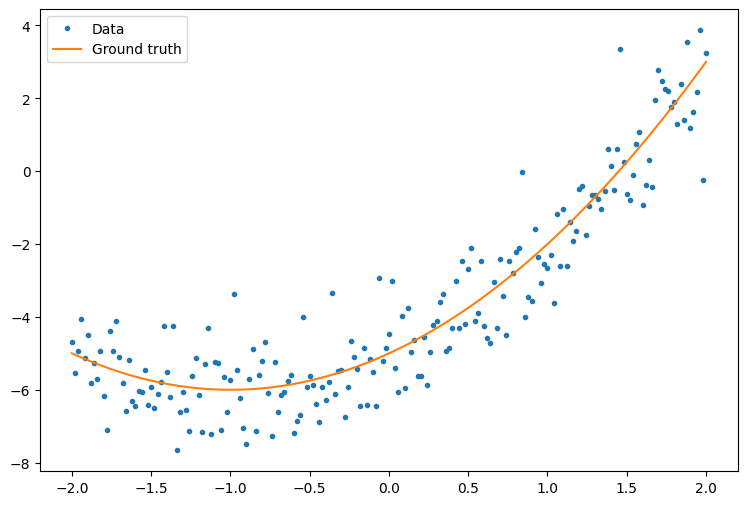

In [ ]:
x = tf.linspace(-2, 2, 201)
x = tf.cast(x, tf.float32)

def f(x):
  y = x**2 + 2*x - 5
  return y

y = f(x) + tf.random.normal(shape=[201])

plt.plot(x.numpy(), y.numpy(), '.', label='Data')
plt.plot(x, f(x), label='Ground truth')
plt.legend();

Create a quadratic model with randomly initialized weights and a bias:

In [ ]:
class Model(tf.Module):

  def __init__(self):
    # Randomly generate weight and bias terms
    rand_init = tf.random.uniform(shape=[3], minval=0., maxval=5., seed=22)
    # Initialize model parameters
    self.w_q = tf.Variable(rand_init[0])
    self.w_l = tf.Variable(rand_init[1])
    self.b = tf.Variable(rand_init[2])

  @tf.function
  def __call__(self, x):
    # Quadratic Model : quadratic_weight * x^2 + linear_weight * x + bias
    return self.w_q * (x**2) + self.w_l * x + self.b

First, observe your model's performance before training:

In [ ]:
quad_model = Model()

In [ ]:
def plot_preds(x, y, f, model, title):
  plt.figure()
  plt.plot(x, y, '.', label='Data')
  plt.plot(x, f(x), label='Ground truth')
  plt.plot(x, model(x), label='Predictions')
  plt.title(title)
  plt.legend()

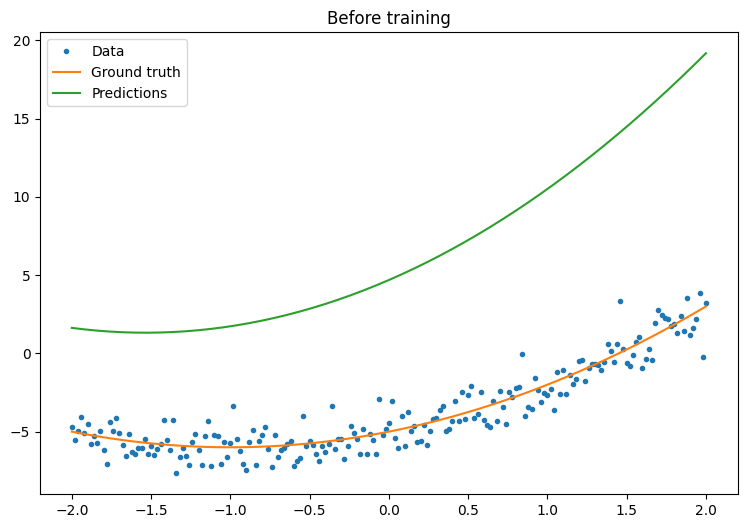

In [ ]:
plot_preds(x, y, f, quad_model, 'Before training')

Now, define a loss for your model:

Given that this model is intended to predict continuous values, the mean squared error (MSE) is a good choice for the loss function. Given a vector of predictions, $\hat{y}$, and a vector of true targets, $y$, the MSE is defined as the mean of the squared differences between the predicted values and the ground truth.

$MSE = \frac{1}{m}\sum_{i=1}^{m}(\hat{y}_i -y_i)^2$

In [ ]:
def mse_loss(y_pred, y):
  return tf.reduce_mean(tf.square(y_pred - y))

Write a basic training loop for the model. The loop will make use of the MSE loss function and its gradients with respect to the input in order to iteratively update the model's parameters. Using mini-batches for training provides both memory efficiency and faster convergence. The `tf.data.Dataset` API has useful functions for batching and shuffling.

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices((x, y))
dataset = dataset.shuffle(buffer_size=x.shape[0]).batch(batch_size)

Mean squared error for step 0: 55.923
Mean squared error for step 10: 9.995
Mean squared error for step 20: 4.033
Mean squared error for step 30: 1.957
Mean squared error for step 40: 1.254
Mean squared error for step 50: 1.006
Mean squared error for step 60: 0.922
Mean squared error for step 70: 0.891
Mean squared error for step 80: 0.881
Mean squared error for step 90: 0.877




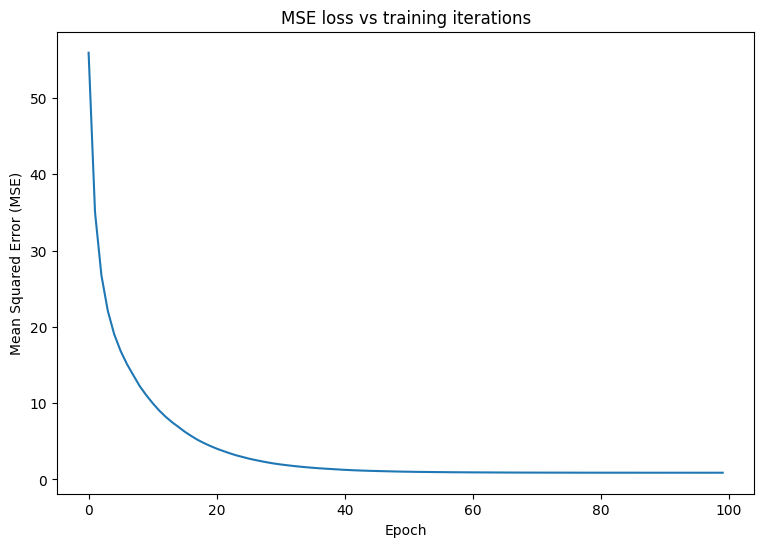

In [ ]:
# Set training parameters
epochs = 100
learning_rate = 0.01
losses = []

# Format training loop
for epoch in range(epochs):
  for x_batch, y_batch in dataset:
    with tf.GradientTape() as tape:
      batch_loss = mse_loss(quad_model(x_batch), y_batch)
    # Update parameters with respect to the gradient calculations
    grads = tape.gradient(batch_loss, quad_model.variables)
    for g,v in zip(grads, quad_model.variables):
        v.assign_sub(learning_rate*g)
  # Keep track of model loss per epoch
  loss = mse_loss(quad_model(x), y)
  losses.append(loss)
  if epoch % 10 == 0:
    print(f'Mean squared error for step {epoch}: {loss.numpy():0.3f}')

# Plot model results
print("\n")
plt.plot(range(epochs), losses)
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE)")
plt.title('MSE loss vs training iterations');

Now, observe your model's performance after training:

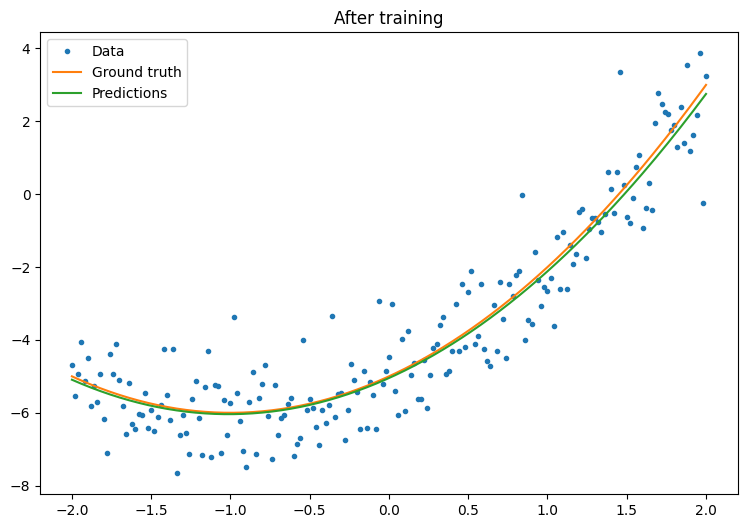

In [ ]:
plot_preds(x, y, f, quad_model, 'After training')

That's working, but remember that implementations of common training utilities are available in the `tf.keras` module. So, consider using those before writing your own. To start with, the `Model.compile` and `Model.fit` methods implement a training loop for you:

Begin by creating a Sequential Model in Keras using `tf.keras.Sequential`. One of the simplest Keras layers is the dense layer, which can be instantiated with `tf.keras.layers.Dense`. The dense layer is able to learn multidimensional linear relationships of the form $\mathrm{Y} = \mathrm{W}\mathrm{X} +  \vec{b}$. In order to learn a nonlinear equation of the form, $w_1x^2 + w_2x + b$, the dense layer's input should be a data matrix with $x^2$ and $x$ as features. The lambda layer, `tf.keras.layers.Lambda`, can be used to perform this stacking transformation.

In [ ]:
new_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.stack([x, x**2], axis=1)),
    tf.keras.layers.Dense(units=1, kernel_initializer=tf.random.normal)])

In [ ]:
new_model.compile(
    loss=tf.keras.losses.MSE,
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01))

history = new_model.fit(x, y,
                        epochs=100,
                        batch_size=32,
                        verbose=0)

new_model.save('./my_new_model')

Observe your Keras model's performance after training:

In [ ]:
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss [Mean Squared Error]')
plt.title('Keras training progress');

In [ ]:
plot_preds(x, y, f, new_model, 'After Training: Keras')

Refer to [Basic training loops](basic_training_loops.ipynb) and the [Keras guide](https://www.tensorflow.org/guide/keras) for more details.